In [1]:
import os
import sys
import glob
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_headers(df):
    return list(df.columns.values)

def HDFS_to_CSV(path,output_file,return_df=False):
    base_dir = path
    ext = ".H5"
    df = pd.DataFrame()
    first_run = True
    for root,dirs,files in os.walk(base_dir):
        files = glob.glob(os.path.join(root,"*"+ext))
        for f in files:
            store = pd.HDFStore(f)
            song_analysis = pd.read_hdf(store,'/analysis/songs')
            metadata = pd.read_hdf(store,'/metadata/songs')
            musicbrainz = pd.read_hdf(store,'musicbrainz/songs')
            frames = [song_analysis,metadata,musicbrainz]
            song_df = pd.concat(frames,axis=1)
            
            if return_df:
                df.append(song_df)

            if first_run:
                song_df.to_csv(output_file)
                first_run = False
            else:
                with open(output_file, 'a') as fl:
                    song_df.to_csv(fl, header=False)
            store.close()
    if return_df:
        return df

def get_songs_df_from_csv(filename):
    return pd.read_csv(filename,index_col=0)   

def clean(df):
    df = df.fillna(0)
    #Drop rows with year = 0
    df = df.drop(df[df.year == 0].index)
    #Drop rows with song hotness = 0
    df = df.drop(df[df.song_hotttnesss==0].index)

    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

def drop_specific_cols(df):
    cols = ['analysis_sample_rate','danceability','energy','genre','artist_7digitalid','audio_md5','analyzer_version','artist_latitude','artist_location','artist_longitude','artist_playmeid','track_7digitalid','release_7digitalid','key_confidence','mode_confidence','time_signature_confidence']
    df = df.drop(cols,axis=1)
    idx_cols = 'idx_'
    return df[df.columns.drop(list(df.filter(regex=idx_cols)))]

In [3]:
#GETTING DATA
songs_df = get_songs_df_from_csv('../assets/msd_summary.csv')

#During the csv making process, I was merging different dfs into one df and df index info was lost. Let's reset the indices
songs_df.reset_index(drop=True,inplace=True)

print "Number of Rows: %d"%len(songs_df)
print "Number of Columns: %d"%len(songs_df.columns)
songs_df.head()

Number of Rows: 1000000
Number of Columns: 53


,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,idx_bars_confidence,idx_bars_start,idx_beats_confidence,idx_beats_start,...,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid,idx_artist_mbtags,year
0,22050,aee9820911781c734e7694c5432990ca,0.0,252.05506,2.049,0.0,0,0,0,0,...,0,0,Monster Ballads X-Mas,633681,0.542899,SOQMMHC12AB0180CB8,Silent Night,7032331,0,2003
1,22050,ed222d07c83bac7689d52753610a513a,0.0,156.55138,0.258,0.0,0,0,0,0,...,0,0,Karkuteillä,145266,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan,1514808,0,1995
2,22050,96c7104889a128fef84fa469d60e380c,0.0,138.97098,0.000,0.0,0,0,0,0,...,0,0,Butter,625706,0.617871,SOGTUKN12AB017F4F1,No One Could Ever,6945353,0,2006
3,22050,0f7da84b6b583e3846c7e022fb3a92a2,0.0,145.05751,0.000,0.0,0,0,0,0,...,0,0,De Culo,199368,NaN,SOBNYVR12A8C13558C,Si Vos Querés,2168257,0,2003
4,22050,228dd6392ad8001b0281f533f34c72fd,0.0,514.29832,0.000,0.0,0,0,0,0,...,0,0,Rene Ablaze Presents Winter Sessions,209038,NaN,SOHSBXH12A8C13B0DF,Tangle Of Aspens,2264873,0,0


In [6]:
#DATA CLEANING
df = clean(songs_df)
df = drop_specific_cols(df)
print "Number of Columns after data cleansing: %d"%len(df.columns)
print "Number of rows after cleansing: %d"%df.year.count()
df.head()

Number of Columns after data cleansing: 19
Number of rows after cleansing: 306298


,duration,end_of_fade_in,key,loudness,mode,start_of_fade_out,tempo,time_signature,track_id,artist_familiarity,artist_hotttnesss,artist_id,artist_mbid,artist_name,release,song_hotttnesss,song_id,title,year
0,252.05506,2.049,10,-4.829,0,236.635,87.002,4,TRMMMYQ128F932D901,0.649822,0.394032,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,Monster Ballads X-Mas,0.542899,SOQMMHC12AB0180CB8,Silent Night,2003
1,156.55138,0.258,9,-10.555,1,148.660,150.778,1,TRMMMKD128F425225D,0.439604,0.356992,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,Karkuteillä,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan,1995
2,138.97098,0.000,7,-2.060,1,138.971,177.768,4,TRMMMRX128F93187D9,0.643681,0.437504,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,Butter,0.617871,SOGTUKN12AB017F4F1,No One Could Ever,2006
13,318.45832,0.502,10,-10.670,1,306.265,67.567,3,TRMMMBW128F4260CAE,0.621826,0.406985,AREMPER1187B9AEB42,14efbb08-c3d8-404c-9ead-ad71fa586ee6,Tiger Lou,The Loyal,0.463490,SOMPVQB12A8C1379BB,Pilots,2005
15,262.26893,0.194,11,-3.925,1,259.419,122.332,4,TRMMMKI128F931D80D,0.529819,0.410229,ARSB5591187B99A848,fba3e876-68f1-4a1f-99d9-c604480202ba,Lena Philipsson,Lena 20 År,0.212045,SOSDCFG12AB0184647,006,1998


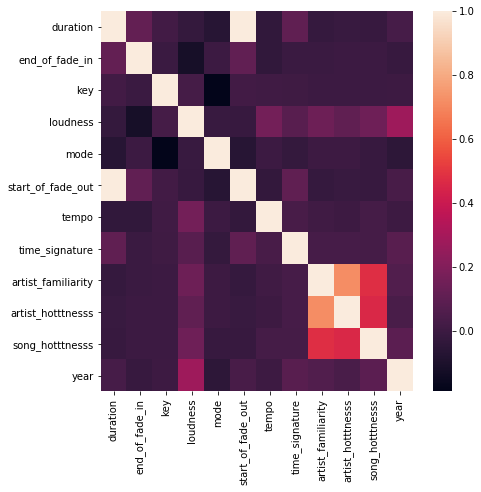

In [7]:
#Data Exploration
corr = df.corr()
plt.figure(figsize = (7,7))
sns.heatmap(corr)

In [8]:
df.describe()

,duration,end_of_fade_in,key,loudness,mode,start_of_fade_out,tempo,time_signature,artist_familiarity,artist_hotttnesss,song_hotttnesss,year
count,306298.000000,306298.000000,306298.000000,306298.000000,306298.000000,306298.000000,306298.000000,306298.000000,306298.000000,306298.000000,306298.000000,306298.000000
mean,245.989623,0.876206,5.313675,-9.289077,0.659779,236.675818,125.457849,3.636984,0.618607,0.430780,0.487166,1999.742339
std,110.965065,2.833747,3.594272,4.789644,0.473784,108.672545,34.916439,1.180530,0.114854,0.095562,0.156768,9.722458
min,0.678730,0.000000,0.000000,-52.559000,0.000000,0.679000,0.000000,0.000000,0.000000,0.000000,0.187701,1922.000000
25%,185.991380,0.000000,2.000000,-11.636000,0.000000,177.946000,99.262250,4.000000,0.546981,0.376689,0.372530,1996.000000
50%,231.078730,0.194000,5.000000,-8.198000,1.000000,221.553000,122.631000,4.000000,0.614654,0.421589,0.485530,2003.000000
75%,284.551380,0.428000,9.000000,-5.852000,1.000000,273.874000,146.489000,4.000000,0.691134,0.480575,0.597641,2007.000000
max,3007.738320,358.214000,11.000000,3.966000,1.000000,3007.738000,280.955000,7.000000,1.000000,1.082503,1.000000,2011.000000


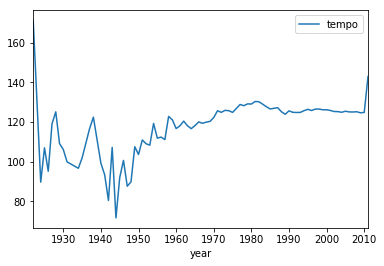

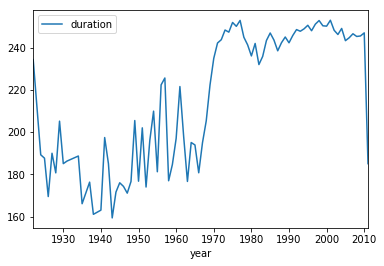

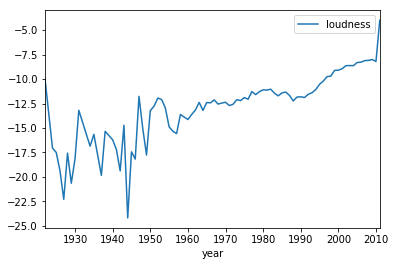

In [9]:
agg_df = df.groupby(df.year).mean().reset_index()
agg_df.plot(x='year',y='tempo')

agg_df.plot(x='year',y='duration')

agg_df.plot(x='year',y='loudness')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000044AFF860>]], dtype=object)

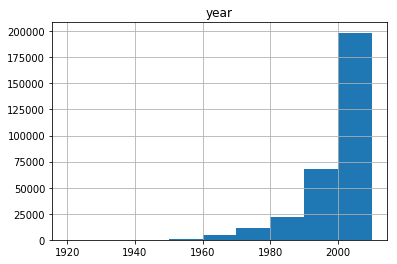

In [10]:
bins = xrange(1920,2020,10)
df.hist(column='year',bins = bins)

In [11]:
#Creating a new feature called isPopular based on if the song hotness is above mean or not
song_hotness_mean = df.song_hotttnesss.mean()#0.487166
threshold = song_hotness_mean
df['isPopular'] = 0
df = df.set_value(df[df.song_hotttnesss>threshold].index,'isPopular',1)

In [12]:
#Most Popular Songs
df.sort_values(by=['song_hotttnesss','year'],ascending=False)[['title','artist_name','release','song_hotttnesss','year']].head(10)

,title,artist_name,release,song_hotttnesss,year
69427,If We Ever Meet Again,Timbaland / Katy Perry,If We Ever Meet Again (Featuring Katy Perry),1.0,2010
78108,Alice,Avril Lavigne,Almost Alice,1.0,2010
85836,Cooler Than Me,Mike Posner,Cooler Than Me,1.0,2010
196742,Somebody To Love,Justin Bieber,My Worlds,1.0,2010
332746,Holiday,Vampire Weekend,Contra,1.0,2010
424919,Nothin' On You [feat. Bruno Mars] (Album Version),B.o.B,B.o.B Presents: The Adventures of Bobby Ray,1.0,2010
711682,Somebody To Love,Justin Bieber,My World 2.0,1.0,2010
712993,Odessa,Caribou,Odessa,1.0,2010
746866,Alice,Avril Lavigne,Alice,1.0,2010
828866,Tighten Up,The Black Keys,Tighten Up,1.0,2010


In [13]:
#Feature Importance and Reduction

from sklearn.ensemble import RandomForestRegressor
X = df.drop(['song_hotttnesss','year','isPopular'],axis=1)
X = X.select_dtypes(exclude=[object])
Y = df['song_hotttnesss'].values

model = RandomForestRegressor(n_estimators=10,max_depth=40)
model.fit(X,Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

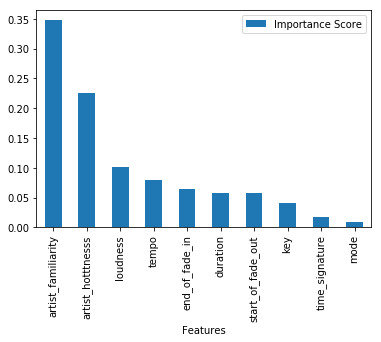

In [14]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.plot(x='Features',y='Importance Score',kind='bar')

In [15]:
#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

X = df.drop('song_hotttnesss',axis=1)
X = X.select_dtypes(exclude=[object])
Y = df['song_hotttnesss'].values

trainX, testX, trainY, testY = train_test_split(X, Y, train_size=0.70)

lm = LinearRegression()

lm.fit(trainX,trainY)

C:\Users\Amninder\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
from sklearn import metrics

pred_train = lm.predict(trainX)
pred_test = lm.predict(testX)

mse_train = metrics.mean_squared_error(trainY,pred_train)
mse_test = metrics.mean_squared_error(testY,pred_test)

r2_train = metrics.r2_score(trainY,pred_train)
r2_test = metrics.r2_score(testY,pred_test)

print "mse_train = %f"%mse_train
print "mse_test = %f"%mse_test
print "r2_train = %f"%r2_train
print "r2_test = %f"%r2_test

mse_train = 0.007225
mse_test = 0.007228
r2_train = 0.706650
r2_test = 0.704386


In [17]:
X = df.drop('song_hotttnesss',axis=1)
X = X.select_dtypes(exclude=[object])
X_top_5_features = X[list(features_df.head().Features)] 
Y = df['song_hotttnesss'].values

trainX, testX, trainY, testY = train_test_split(X_top_5_features, Y, train_size=0.70)

lm = LinearRegression()

lm.fit(trainX,trainY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
pred_train = lm.predict(trainX)
pred_test = lm.predict(testX)

mse_train = metrics.mean_squared_error(trainY,pred_train)
mse_test = metrics.mean_squared_error(testY,pred_test)

r2_train = metrics.r2_score(trainY,pred_train)
r2_test = metrics.r2_score(testY,pred_test)

print "mse_train = %f"%mse_train
print "mse_test = %f"%mse_test
print "r2_train = %f"%r2_train
print "r2_test = %f"%r2_test

mse_train = 0.018117
mse_test = 0.018244
r2_train = 0.261507
r2_test = 0.260736


In [19]:
#K-Neighbors Regressor
from sklearn import neighbors
X = df.drop('song_hotttnesss',axis=1)
X = X.select_dtypes(exclude=[object])
X_top_5_features = X[list(features_df.head().Features)] 
Y = df['song_hotttnesss'].values

trainX, testX, trainY, testY = train_test_split(X_top_5_features, Y, train_size=0.70)
knn_regressor = neighbors.KNeighborsRegressor(n_neighbors=5, weights='uniform')
knn_regressor.fit(trainX,trainY)
knn_regressor.predict(testX)
knn_regressor.score(testX,testY)

0.024109413511750777

In [30]:
#KNN

X = df.drop('song_hotttnesss',axis=1)
X = X.select_dtypes(exclude=[object])
X_top_5_features = X[list(features_df.head().Features)] 
Y = df['isPopular'].values

trainX, testX, trainY, testY = train_test_split(X_top_5_features, Y, train_size=0.70)

knn = neighbors.KNeighborsClassifier(n_neighbors=100, weights='uniform')
knn.fit(trainX,trainY)

knn.predict(testX)
knn_score = knn.score(testX,testY)
knn_score

0.59594079878115136

In [31]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

lr = LogisticRegression()
lr.fit(trainX,trainY)

predicted = lr.predict(testX)
probs = lr.predict_proba(testX)
lr_score = metrics.accuracy_score(testY, predicted)
print "Accuracy score = %f"%lr_score
print "ROC AUC Score = %f"%roc_auc_score(testY, probs[:,1])
print "==================================================="
print "Confusion Matrix"
print metrics.confusion_matrix(testY, predicted)
print "==================================================="
print metrics.classification_report(testY, predicted)

Accuracy score = 0.695244
ROC AUC Score = 0.758019
Confusion Matrix
[[33850 12641]
 [15363 30036]]
             precision    recall  f1-score   support

          0       0.69      0.73      0.71     46491
          1       0.70      0.66      0.68     45399

avg / total       0.70      0.70      0.69     91890



In [22]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(lr, X_top_5_features, Y, scoring='accuracy', cv=5)
print scores
print scores.mean()

[ 0.69964087  0.69691479  0.6920666   0.69281248  0.69558759]
0.695404467516


In [23]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier()
model_dt.fit(X_top_5_features,Y)
scores_dt = cross_val_score(model_dt,X_top_5_features,Y,scoring='accuracy',cv=5)
print scores_dt
print scores_dt.mean()

[ 0.71550767  0.71745021  0.71340189  0.71780473  0.71498066]
0.715829032926


In [24]:
dt_f1_scores = cross_val_score(model_dt,X_top_5_features,Y,scoring='f1',cv=5)
print dt_f1_scores
print dt_f1_scores.mean()

[ 0.71234818  0.71626701  0.71366331  0.71632757  0.71356205]
0.714433625806


In [25]:
dt_roc_scores = cross_val_score(model_dt,X_top_5_features,Y,scoring='roc_auc',cv=5)
print dt_roc_scores
print dt_roc_scores.mean()

[ 0.71475545  0.7179143   0.71510133  0.71850351  0.71673372]
0.716601661261


In [26]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=15)
model_rf.fit(X_top_5_features,Y)

scores_rf = cross_val_score(model_rf,X_top_5_features,Y,scoring='accuracy',cv=5)
print scores_rf
print scores_rf.mean()

[ 0.74866144  0.75176298  0.74577212  0.74948987  0.74779216]
0.748695714274


In [27]:
rf_f1_scores = cross_val_score(model_rf,X_top_5_features,Y,scoring='f1',cv=5)
print rf_f1_scores
print rf_f1_scores.mean()

[ 0.74929614  0.74860572  0.74527067  0.742264    0.74747145]
0.746581596429


In [28]:
rf_roc_scores = cross_val_score(model_rf,X_top_5_features,Y,scoring='roc_auc',cv=5)
print rf_roc_scores.mean()

0.821924709361


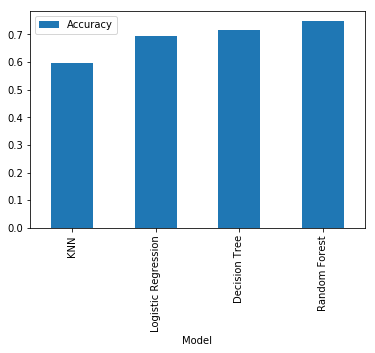

In [33]:
d = {'Model':['KNN','Logistic Regression','Decision Tree','Random Forest'],'Accuracy':[knn_score,scores.mean(),scores_dt.mean(),scores_rf.mean()]}

agg_scores = pd.DataFrame(data = d)
agg_scores.plot(x='Model',y='Accuracy',kind='bar')

In [40]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(model_rf,X_top_5_features,Y,cv=5)

print metrics.confusion_matrix(Y,y_pred)


[[114629  39604]
 [ 37628 114437]]


In [39]:
print metrics.classification_report(Y, y_pred)

             precision    recall  f1-score   support

          0       0.75      0.74      0.75    154233
          1       0.74      0.75      0.75    152065

avg / total       0.75      0.75      0.75    306298



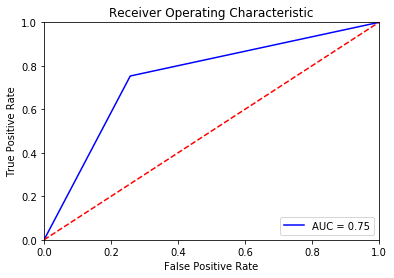

In [37]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(Y,y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()